Цель ноутбука: понять, как можно представлять дефекты в числовом виде

In [2]:
import sys
sys.path.append('..')

from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
import nglview
import numpy as np
import pandas as pd

from scripts.utils import structures_to_df, read_json_structures, RootPath

def show(x): return nglview.show_pymatgen(x)

/Users/tomatoparetogmail.com/Desktop/Github/idao_22/env/lib/python3.8/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: 'NoneType' object is not iterable. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")


In [4]:
df_public, df_private = structures_to_df()

df_public = df_public.merge(
    read_json_structures(RootPath('data/dichalcogenides_public/defects', True)
                         ).rename({'structure': 'diff'}, axis=1), on=['_id'])
                         
df_private = df_private.merge(
    read_json_structures(RootPath('data/dichalcogenides_private/defects', True)
                         ).rename({'structure': 'diff'}, axis=1), on=['_id'])

2966it [00:01, 1506.48it/s]
2967it [00:01, 1493.63it/s]


In [4]:
df_public.formula.value_counts()

Mo63 W1 Se1 S126    716
Mo63 Se1 S126       702
Mo63 W1 S126        380
Mo63 Se2 S126       377
Mo63 S126           363
Mo63 W1 Se2 S126    360
Mo64 Se1 S126        18
Mo64 S126            12
Mo63 W1 S127          8
Mo64 Se2 S126         8
Mo63 S127             8
Mo63 Se1 S127         7
Mo63 W1 Se1 S127      5
Mo63 W1 S128          1
Mo63 S128             1
Name: formula, dtype: int64

### Naive approach

Всего максимум три дефекта у материалов. Создадим вектор признаков каждого материала следующим образом:
$$ [\underbrace{x_1, y_1, z_1}_{дефект_1}, \underbrace{x_2, y_2, z_2}_{дефект_2},
 \underbrace{x_3, y_3, z_3}_{дефект_3},
 \underbrace{W_1, Mo_1, Se_1, S_1, \emptyset_1}_{дефект_1},
  \underbrace{W_2, Mo_2, Se_2, S_2, \emptyset_2}_{дефект_2},
   \underbrace{W_3, Mo_3, Se_3, S_3, \emptyset_3}_{дефект_3}] \in \mathbb{R}^{24} $$

где:
   1. $x_i, y_i, z_i$ - координаты $i$-го атома в дефекте
   2. $W_i, Mo_i, Se_i, S_i, \emptyset_i$ - описание типа $i$-го атома в дефекте. К примеру, если 
   3. $ \emptyset_i $ указывает на ситуацию, когда дефект состоит из одного-двух атомов

In [5]:
def encode_structures(structures: pd.Series) -> np.array:

    results = []

    for _, lattice in tqdm(structures.iteritems()):
        lattice.sort()
        coordinates = lattice.frac_coords.flatten()

        # если дефект состоит из одного/двух атомов, то заполняем
        # нулями информацию о координатах дефектов 2 и 3
        if len(coordinates) != 9:
            coordinates = np.append(coordinates, [0] * (9 - len(coordinates)))

        for atom in lattice:
            formula = str(atom._species)
            
            # кодирую пятизначным вектором, чтобы избежать perfect multicollinearity
            if formula == 'W1':
                to_append = [1, 0, 0, 0, 0]
            elif formula == 'Mo1':
                to_append = [0, 1, 0, 0, 0]
            elif formula == 'Se1':
                to_append = [0, 0, 1, 0, 0]
            elif formula == 'S1':
                to_append = [0, 0, 0, 1, 0]

            coordinates = np.append(coordinates, to_append)

        # если дефект состоит из одного/двух атомов,
        # то заполняем нулями информацию о типах дефектов 2 и 3
        if len(coordinates) != (9 + 5 * 3):
            coordinates = np.append(coordinates, [0] * ((9 + 5 * 3) - len(coordinates)))

        results.append(coordinates)
        
    return np.array(results)

results = encode_structures(df_public['diff'])


2966it [00:00, 8857.49it/s]


### Линейная регрессия

In [11]:
data = pd.DataFrame(results).astype(dtype={9: int, 10: int, 11: int, 12: int,
                                    13: int, 14: int, 15: int, 16: int, 17: int, 18: int, 19: int,
                                    20: int, 21: int, 22: int, 23: int})

In [16]:
data

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.916667,0.958333,0.250000,0.708333,0.166667,0.144826,0.458333,0.916667,0.355174,0,...,0,0,0,1,0,0,0,0,1,0
1,0.666667,0.958333,0.250000,0.583333,0.291667,0.144826,0.208333,0.791667,0.144826,1,...,0,0,1,0,0,0,0,0,1,0
2,0.833333,0.541667,0.355174,0.583333,0.041667,0.144826,0.000000,0.000000,0.000000,0,...,0,0,1,0,0,0,0,0,0,0
3,0.041667,0.458333,0.250000,0.833333,0.166667,0.144826,0.833333,0.416667,0.144826,1,...,0,0,1,0,0,0,0,0,1,0
4,0.666667,0.583333,0.250000,0.083333,0.416667,0.144826,0.333333,0.541667,0.355174,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,0.791667,0.583333,0.250000,0.958333,0.666667,0.144826,0.458333,0.291667,0.355174,1,...,0,0,1,0,0,0,0,0,1,0
2963,0.291667,0.458333,0.250000,0.833333,0.166667,0.355174,0.083333,0.791667,0.355174,0,...,0,0,1,0,0,0,0,0,1,0
2964,0.291667,0.833333,0.250000,0.958333,0.041667,0.144826,0.458333,0.541667,0.355174,1,...,0,0,1,0,0,0,0,0,1,0
2965,0.541667,0.458333,0.250000,0.833333,0.916667,0.355174,0.833333,0.541667,0.144826,0,...,0,0,1,0,0,0,0,0,1,0


In [17]:
results_test = encode_structures(df_private['diff'])
data = pd.DataFrame(results_test).astype(dtype={9: int, 10: int, 11: int, 12: int,
                                    13: int, 14: int, 15: int, 16: int, 17: int, 18: int, 19: int,
                                    20: int, 21: int, 22: int, 23: int})

2967it [00:00, 9358.88it/s]


In [80]:
X = sm.add_constant(results)
y = df_public['band_gap']


m = sm.OLS(y, X)
res = m.fit()

In [74]:
res.summary(xname=['const', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2', 'z_2', 'x_3', 'y_3', 'z_3',
                   'W_1', 'Mo_1', 'Se_1', 'S_1', 'NO_1',
                   'W_2', 'Mo_2', 'Se_2', 'S_2', 'NO_2',
                   'W_3', 'Mo_3', 'Se_3', 'S_3', 'NO_3',
                   ])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               band_gap   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     1585.
Date:                Tue, 08 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:44:26   Log-Likelihood:                 1156.5
No. Observations:                2966   AIC:                            -2279.
Df Residuals:                    2949   BIC:                            -2177.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9227      0.108      8.568      0.000       0.712       1.134
x_1           -0.0013      0.011     -0.125      0.901      -0.022       0.019
y_1        -5.479e-05      0.010     -0.005      0.996      -0.021       0.020
z_1            0.5589      0.276      2.023      0.043       0.017       1.101
x_2           -0.0067      0.011     -0.633      0.527      -0.027       0.014
y_2            0.0017      0.011      0.157      0.875      -0.019       0.022
z_2            0.0023      0.029      0.080      0.936      -0.054       0.059
x_3           -0.0047      0.011     -0.435      0.664      -0.026       0.017
y_3            0.0022      0.011      0.199      0.842      -0.019       0.023
z_3           -0.0007      0.029     -0.024      0.981      -0.058       0.057
W_1            0.4782      0.033     14.491      0.000       0.414       0.543
Mo_1          -0.4416      0.033    -13.356      0.000      -0.506      -0.377
Se_1           0.5986      0.039     15.205      0.000       0.521       0.676
S_1            0.2875      0.049      5.831      0.000       0.191       0.384
NO_1       -2.933e-16   2.64e-16     -1.109      0.267   -8.12e-16    2.25e-16
W_2        -3.759e-17    1.3e-17     -2.883      0.004   -6.32e-17    -1.2e-17
Mo_2       -2.033e-18   1.42e-18     -1.429      0.153   -4.82e-18    7.57e-19
Se_2          -0.2449      0.119     -2.051      0.040      -0.479      -0.011
S_2           -0.2978      0.119     -2.492      0.013      -0.532      -0.063
NO_2                0          0        nan        nan           0           0
W_3                 0          0        nan        nan           0           0
Mo_3                0          0        nan        nan           0           0
Se_3           0.2499      0.028      8.808      0.000       0.194       0.306
S_3           -0.0681      0.028     -2.448      0.014      -0.123      -0.014
NO_3                0          0        nan        nan           0           0
==============================================================================
Omnibus:                        7.385   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                6.632
Skew:                          -0.065   Prob(JB):                       0.0363
Kurtosis:                       2.809   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [263]:
data = pd.DataFrame(results).astype(dtype={9: int, 10: int, 11: int, 12: int,
                                    13: int, 14: int, 15: int, 16: int, 17: int, 18: int, 19: int,
                                    20: int, 21: int, 22: int, 23: int})

train_pool = train_pool = Pool(data,
                               y,
                               cat_features=[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

# specify the training parameters
model = CatBoostRegressor(iterations=1000,
                          depth=9,
                          learning_rate=0.8,
                          loss_function='MAE')
# train the model
model.fit(train_pool)


0:	learn: 0.1008256	total: 3.05ms	remaining: 3.05s
1:	learn: 0.0466170	total: 5.29ms	remaining: 2.64s
2:	learn: 0.0405402	total: 7.93ms	remaining: 2.63s
3:	learn: 0.0278413	total: 9.74ms	remaining: 2.42s
4:	learn: 0.0255922	total: 12ms	remaining: 2.4s
5:	learn: 0.0245882	total: 16ms	remaining: 2.65s
6:	learn: 0.0228830	total: 18.4ms	remaining: 2.61s
7:	learn: 0.0224562	total: 20.5ms	remaining: 2.54s
8:	learn: 0.0219699	total: 22.7ms	remaining: 2.5s
9:	learn: 0.0217033	total: 25.4ms	remaining: 2.51s
10:	learn: 0.0210074	total: 27.7ms	remaining: 2.49s
11:	learn: 0.0195720	total: 30.6ms	remaining: 2.52s
12:	learn: 0.0188492	total: 33.6ms	remaining: 2.55s
13:	learn: 0.0177332	total: 35.7ms	remaining: 2.52s
14:	learn: 0.0172887	total: 37.5ms	remaining: 2.46s
15:	learn: 0.0167761	total: 39.2ms	remaining: 2.41s
16:	learn: 0.0160618	total: 41.1ms	remaining: 2.38s
17:	learn: 0.0159277	total: 43.2ms	remaining: 2.35s
18:	learn: 0.0156093	total: 44.9ms	remaining: 2.32s
19:	learn: 0.0152053	total: 

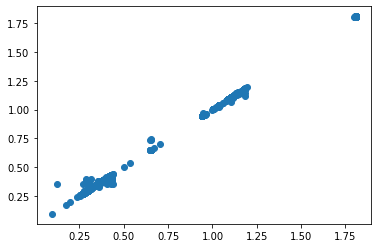

In [264]:
plt.scatter(y, model.predict(data))